In [1]:
# -*- coding: utf-8 -*-

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

import tensorflow as tf
import numpy as np
import time

from plot_loader import plot_data


def initialize_session():
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    return tf.Session(config=config)

train_acc_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_acc_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다



/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
##################################################
max_len = 500           # sequence 단어 수 제한
max_vocab = 30000       # maximum 단어 개수
BATCH_SIZE = 10         # 배치 사이즈
emb_dim = 128            # 단어 embedding dimension
hidden_dim = 128        # RNN hidden dim
learning_rate = 0.001  # Learning rate
use_clip = True         # Gradient clipping 쓸지 여부
class_size = 4
train_acc_summary = [] # 학습용 데이터의 정확도를 중간 중간 기록한다
test_acc_summary = []  # 테스트용 데이터의 정확도를 중간 중간 기록한다
train_loss_summary = [] # 학습용 데이터의 정확도를 중간 중간 기록한다
test_loss_summary = []  # 테스트용 데이터의 정확도를 중간 중간 기록한다
##################################################
data = plot_data(max_vocab=max_vocab, max_len=max_len)
from genre_movie_rnn import Model
END_TOKEN = "<eos>"
model = Model(max_len=max_len,
              emb_dim=emb_dim,
              hidden_dim=hidden_dim,
              vocab_size=max_vocab,
              class_size=class_size,
              use_clip=True, learning_rate=learning_rate, end_token=data.w2idx[END_TOKEN])

sess = initialize_session()
sess.run(tf.global_variables_initializer())

In [3]:
def test_model():
    total_batch = int(len(data.test_ids) / BATCH_SIZE)
    test_loss, test_acc = 0, 0
        
    for _ in range(total_batch):
        test_ids, length, label = data.get_test(BATCH_SIZE)
        loss, acc = sess.run([model.loss, model.accuracy], feed_dict={model.x: test_ids, model.x_len: length, model.y: label})

        test_loss += loss
        test_acc += acc
        
    return test_loss/total_batch, test_acc/ total_batch
#     print(" --> test_loss: {:.3f} | test_acc: {:.3f}".format(test_loss / test_cnt, same/test_cnt/BATCH_SIZE))

total_batch = int(len(data.train_ids) / BATCH_SIZE)
for epoch in range(15):
    
    train_avg_loss, train_avg_acc = 0, 0
    
    for it in range(total_batch):
        train_ids, length, label = data.get_train(BATCH_SIZE)
        
        loss, acc, _, = sess.run([model.loss, model.accuracy, model.update],
                            feed_dict={model.x: train_ids, model.x_len: length, model.y: label, model.keep_prob: 0.75})
        train_avg_loss += loss / total_batch
        train_avg_acc += acc / total_batch

    test_avg_loss, test_avg_acc = test_model()
    
    train_acc_summary.append(train_avg_acc)
    test_acc_summary.append(test_avg_acc)
    train_loss_summary.append(train_avg_loss)
    test_loss_summary.append(test_avg_loss)
    
    print("epoch {} - train_loss: {:.4f}, train_acc: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}"
          .format(epoch+1, train_avg_loss, train_avg_acc, test_avg_loss, test_avg_acc))  
    


epoch 1 - train_loss: 1.0703, train_acc: 0.5240, test_loss: 0.8607, test_acc: 0.6689
epoch 2 - train_loss: 0.4685, train_acc: 0.8385, test_loss: 0.6961, test_acc: 0.7585
epoch 3 - train_loss: 0.1233, train_acc: 0.9617, test_loss: 0.7766, test_acc: 0.7594
epoch 4 - train_loss: 0.0393, train_acc: 0.9883, test_loss: 0.9273, test_acc: 0.7248
epoch 5 - train_loss: 0.0177, train_acc: 0.9933, test_loss: 1.1448, test_acc: 0.7198
epoch 6 - train_loss: 0.0136, train_acc: 0.9940, test_loss: 0.9843, test_acc: 0.7795
epoch 7 - train_loss: 0.0345, train_acc: 0.9881, test_loss: 1.0093, test_acc: 0.7114
epoch 8 - train_loss: 0.0256, train_acc: 0.9910, test_loss: 1.1157, test_acc: 0.6955
epoch 9 - train_loss: 0.0245, train_acc: 0.9900, test_loss: 1.0730, test_acc: 0.7106
epoch 10 - train_loss: 0.0127, train_acc: 0.9944, test_loss: 1.1463, test_acc: 0.7484
epoch 11 - train_loss: 0.0117, train_acc: 0.9942, test_loss: 1.1908, test_acc: 0.7576
epoch 12 - train_loss: 0.0116, train_acc: 0.9940, test_loss: 1.

Max Train Accuracy 0.99%
Max Test Accuracy 0.78%


Text(0.5,0.98,'TEST')

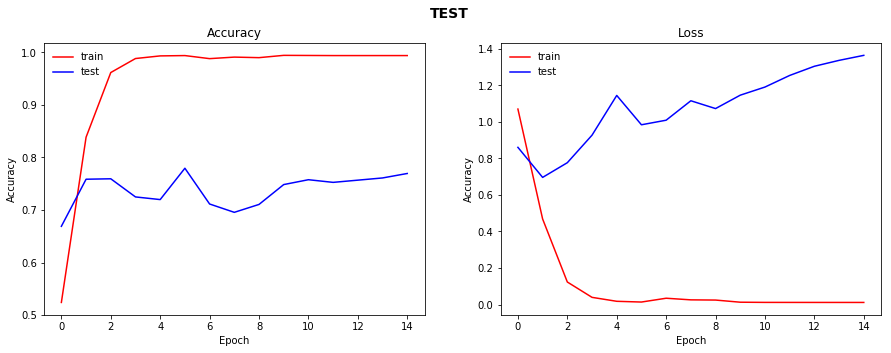

In [6]:
print('Max Train Accuracy {:.2f}%'.format(np.max(np.max(train_acc_summary))))
print('Max Test Accuracy {:.2f}%'.format(np.max(test_acc_summary)))

import matplotlib.pyplot as plt

# Get the figure and the axes
fig, (acc, loss) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(15, 5))

# 첫번째 그래프
acc.plot(train_acc_summary, 'r', label='train')
acc.plot(test_acc_summary, 'b', label='test')
acc.legend(loc='upper left', frameon=False)
acc.set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')

# 두번째 그래프
loss.plot(train_loss_summary, 'r', label='train')
loss.plot(test_loss_summary, 'b', label='test')
loss.legend(loc='upper left', frameon=False)
loss.set(title='Loss', xlabel='Epoch', ylabel='Accuracy')

# Title the figure
fig.suptitle('TEST', fontsize=14, fontweight='bold')

In [5]:
print(tf.one_hot(tf.to_int32(tf.reshape(label, [-1])), 4, 1.0, 0.0))

Tensor("one_hot_1:0", shape=(10, 4), dtype=float32)


In [ ]:
train_ids[3]

In [ ]:
train_ids